In [1]:
import os
import tqdm
import math
import numpy as np
import scipy
import densratio
import networkx
import pandas
import matplotlib.pyplot as plt
% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly
plotly.offline.init_notebook_mode(connected=True)
import seaborn
seaborn.set_style('ticks')

## Density Ratio Estimation via KLIEP

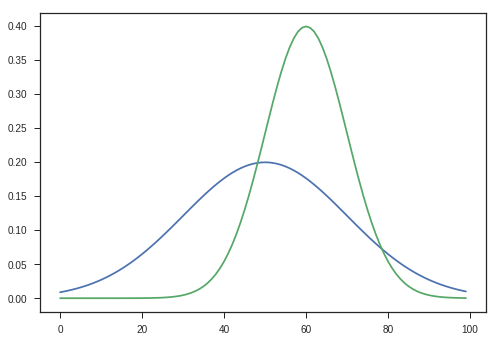

In [2]:
plt.plot([scipy.stats.norm(0, 2).pdf(x) for x in np.arange(-5, 5, 0.1)])
plt.plot([scipy.stats.norm(1, 1).pdf(x) for x in np.arange(-5, 5, 0.1)])

In [3]:
data_tr = scipy.stats.norm(0, 2).rvs(1000)
data_te = scipy.stats.norm(1, 1).rvs(100)
df_tr = pandas.DataFrame(data_tr)
df_te = pandas.DataFrame(data_te)
df_tr[:5]

,0
0,-0.009071
1,0.109513
2,1.404517
3,-0.473089
4,0.592858


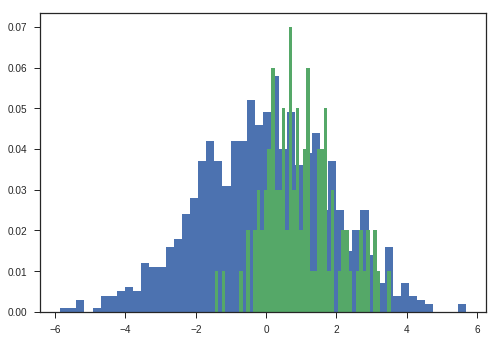

In [4]:
weights_tr = np.ones_like(df_tr)/len(df_tr)
weights_te = np.ones_like(df_te)/len(df_te)
plt.hist(df_tr, bins=50, weights=weights_tr)
plt.hist(df_te, bins=50, weights=weights_te)
plt.show()

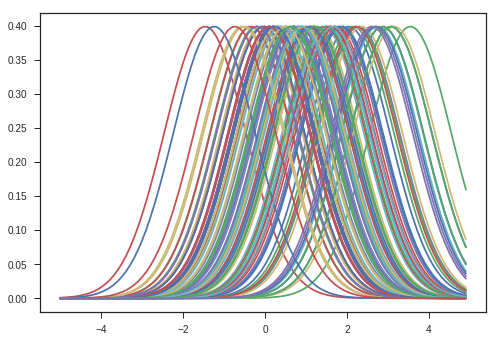

In [5]:
def norm(mu): return lambda x: scipy.stats.norm.pdf(x, loc=mu, scale=1)
bases = [norm(mu) for mu in data_te]
for i in range(len(data_te)):
    plt.plot(np.arange(-5, 5, 0.1), [bases[i](x) for x in np.arange(-5, 5, 0.1)])

In [6]:
def true_ratio(x):
    return scipy.stats.norm(1, 1).pdf(x) / scipy.stats.norm(0, 2).pdf(x)

In [7]:
def kliep_old(bases, trX, teX):
    n_tr = len(trX)
    n_te = len(teX)
    n_b = len(bases)
    # init
    A = np.zeros([n_te, n_b])
    b = np.zeros(n_b)
    for l in range(n_b):
        for j in range(n_te):
            A[j, l] = bases[l](teX[j])
        for i in range(n_tr):
            b[l] += bases[l](trX[i])
        b[l] /= n_tr
    alpha = np.random.uniform(0, 1, n_b)
    epsilon = 1e-6
    # update
    while True:
        alpha_ = np.copy(alpha)
        # gradient ascent
        alpha += epsilon * A.transpose().dot(1 / A.dot(alpha))
        # penalty?
        alpha += (1 - b.dot(alpha)) * b / (b.dot(b))
        # non-negative constraint
        for l in range(n_b):
            alpha[l] = max(alpha[l], 0)
        # sum equals to 1 constraint
        alpha = alpha / (b.dot(alpha))
        if np.square(alpha_ - alpha).sum() < 1e-6:
            return lambda x: sum(map(lambda t: t[0] * t[1](x), zip(alpha, bases)))

In [8]:
# initialization (time consuming)
n_tr = len(data_tr)
n_te = len(data_te)
n_b = len(bases)
A = np.zeros([n_te, n_b])
b = np.zeros(n_b)
for l in range(n_b):
    for j in range(n_te):
        A[j, l] = bases[l](data_te[j])
    for i in range(n_tr):
        b[l] += bases[l](data_tr[i])
    b[l] /= n_tr

In [9]:
def fun(alpha):
    return -np.sum(np.log(alpha.dot(A)))

def jac(alpha):
    return -A.transpose().dot(1 / A.dot(alpha))

bounds = [(0, None) for _ in range(n_b)]
constraints = [{'type': 'eq', 'fun': lambda alpha: alpha.dot(b) - 1}]

print('grad error: %f' % scipy.optimize.check_grad(fun, jac, np.random.uniform(0, 1, n_b)))

grad error: 0.000016


In [10]:
alpha0 = np.random.uniform(0, 1, n_b)
result = scipy.optimize.minimize(fun=fun, jac=jac, x0=alpha0, method='SLSQP', bounds=bounds, constraints=constraints)


def approximated_ratio(x):
    return sum(map(lambda t: t[0] * t[1](x), zip(result.x, bases)))

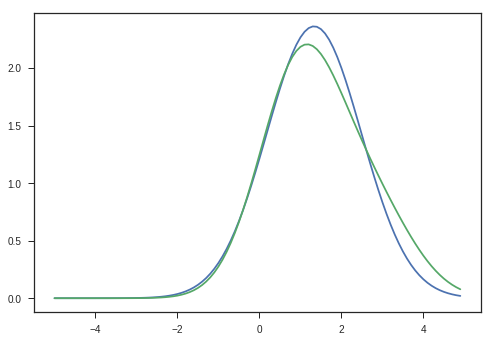

In [11]:
plt.plot(np.arange(-5, 5, 0.1), [true_ratio(x) for x in np.arange(-5, 5, 0.1)])
plt.plot(np.arange(-5, 5, 0.1), [approximated_ratio(x) for x in np.arange(-5, 5, 0.1)])

## Maximum Likelihood Mutual Information (MLMI)

In [12]:
n_b = 200
n = 3000
true_cov = np.array([[1, 0.2], [0.2, 1]])
data = scipy.stats.multivariate_normal(mean=[0, 0], cov=true_cov).rvs(n)
print('shape: %s' % list(data.shape))
print(data[:5])

shape: [3000, 2]
[[-1.26746826  2.30148078]
 [-0.50920064 -0.76349627]
 [-0.06818916 -1.06800389]
 [-0.05206005  0.18279424]
 [-1.08387109  0.62999703]]


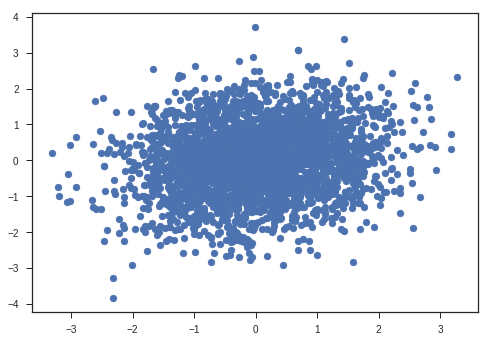

In [13]:
plt.scatter(data[:, 0], data[:, 1])

In [14]:
# initialization
indices = np.random.choice(range(n), n_b)
means = data[indices]
cov = np.eye(2)
pre = np.linalg.inv(cov)
A = np.transpose([scipy.stats.multivariate_normal.pdf(x=data, mean=mean, cov=cov) for mean in means])
b_x = np.sum([scipy.stats.norm.pdf(x=data[:, 0], loc=mean[0], scale=cov[0, 0]) for mean in means], axis=1)
b_y = np.sum([scipy.stats.norm.pdf(x=data[:, 1], loc=mean[1], scale=cov[1, 1]) for mean in means], axis=1)
# A = np.transpose([np.exp(-0.5 * np.array([np.transpose(x - mean).dot(pre).dot(x - mean) for x in data])) for mean in means])
# b_x = np.sum([np.exp(-0.5 * np.square(data[:, 0] - mean[0]) / cov[0, 0]) for mean in means], axis=1)
# b_y = np.sum([np.exp(-0.5 * np.square(data[:, 1] - mean[1]) / cov[1, 1]) for mean in means], axis=1)
b_xy = np.sum(A, axis=0)
b = (b_x * b_y - b_xy) / n / (n - 1)
print('A.shape: %s' % list(A.shape))

A.shape: [3000, 200]


In [15]:
def fun(alpha):
    return -np.sum(np.log(A.dot(alpha)))

def jac(alpha):
    return -A.transpose().dot(1 / A.dot(alpha))

bounds = [(0, None) for _ in range(n_b)]
constraints = [{'type': 'eq', 'fun': lambda alpha: alpha.dot(b) - 1}]

print('grad error: %f' % scipy.optimize.check_grad(fun, jac, np.random.uniform(0, 1, n_b)))

grad error: 0.000623


In [16]:
alpha0 = np.random.uniform(0, 1, n_b)
result = scipy.optimize.minimize(fun=fun, jac=jac, x0=alpha0, method='SLSQP', bounds=bounds, constraints=constraints)

In [17]:
def true_ratio(x):
    return scipy.stats.multivariate_normal(mean=[0, 0], cov=true_cov).pdf(x) / scipy.stats.norm(0, 1).pdf(x[0]) / scipy.stats.norm(0, 1).pdf(x[1])

def approximated_ratio(x):
    return sum(map(lambda t: t[0] * t[1](x), zip(result.x, [scipy.stats.multivariate_normal(mean=mean, cov=cov).pdf for mean in means])))

In [18]:
d = 2
n = 20
X, Y = np.meshgrid(np.linspace(-d, d, n), np.linspace(-d, d, n))
X, Y = X.flatten(), Y.flatten()
# points = np.transpose(np.reshape([X, Y], [2, n**2]))
points = np.transpose([X, Y])
Z = np.reshape([true_ratio(point) for point in points], [n, n])
W = np.reshape([approximated_ratio(point) for point in points], [n, n])
trace1 = plotly.graph_objs.Mesh3d(x=X.flatten(), y=Y.flatten(), z=Z.flatten(), name='True ratio')
trace2 = plotly.graph_objs.Mesh3d(x=X.flatten(), y=Y.flatten(), z=W.flatten(), name='Approximated ratio', opacity=0.80)
plotly.offline.iplot([trace1, trace2])

### Mutual Information (MI) in a Gaussian setting
$$
I(x_1, x_2) = H(x_1) + H(x_2) - H(x_1, x_2)
$$
$$
= \frac{1}{2}(1 + \ln(2\pi\Sigma_{11})) + \frac{1}{2}(1 + \ln(2\pi\Sigma_{22})) - \left\{1 + \ln(2\pi) + \frac{1}{2}\ln\det\Sigma\right\}
$$
$$
= \ln(\Sigma_{11}\Sigma_{22}) - \frac{1}{2}\ln\left(\Sigma_{11}\Sigma_{22} - \Sigma_{12}^2\right) = -\frac{1}{2}\ln\left(1 - \frac{\Sigma_{12}^2}{\Sigma_{11}\Sigma_{22}}\right)
$$
cf. PRML(eq. 2.283)

In [19]:
print('Expected MI: %f' % (-0.5 * np.log(1 - true_cov[0, 1]**2 / true_cov[0, 0] / true_cov[1, 1])))
print('Approximated MI: %f' % np.mean(np.log(A.dot(result.x))))

Expected MI: 0.020411
Approximated MI: 0.011511


In [20]:
def mutual_information(c):
    n_b = 200
    n = 3000
    true_cov = np.array([[1, c], [c, 1]])
    data = scipy.stats.multivariate_normal(mean=[0, 0], cov=true_cov).rvs(n)

    # initialization
    indices = np.random.choice(range(n), n_b)
    means = data[indices]
    cov = np.eye(2)
    pre = np.linalg.inv(cov)
    A = np.transpose([scipy.stats.multivariate_normal.pdf(x=data, mean=mean, cov=cov) for mean in means])
    b_x = np.sum([scipy.stats.norm.pdf(x=data[:, 0], loc=mean[0], scale=cov[0, 0]) for mean in means], axis=1)
    b_y = np.sum([scipy.stats.norm.pdf(x=data[:, 1], loc=mean[1], scale=cov[1, 1]) for mean in means], axis=1)
    b_xy = np.sum(A, axis=0)
    b = (b_x * b_y - b_xy) / n / (n - 1)

    def fun(alpha):
        return -np.sum(np.log(A.dot(alpha)))

    def jac(alpha):
        return -A.transpose().dot(1 / A.dot(alpha))

    bounds = [(0, None) for _ in range(n_b)]
    constraints = [{'type': 'eq', 'fun': lambda alpha: alpha.dot(b) - 1}]

    alpha0 = np.random.uniform(0, 1, n_b)
    result = scipy.optimize.minimize(fun=fun, jac=jac, x0=alpha0, method='SLSQP', bounds=bounds, constraints=constraints)

    def true_ratio(x):
        return scipy.stats.multivariate_normal(mean=[0, 0], cov=true_cov).pdf(x) / scipy.stats.norm(0, 1).pdf(x[0]) / scipy.stats.norm(0, 1).pdf(x[1])

    def approximated_ratio(x):
        return sum(map(lambda t: t[0] * t[1](x), zip(result.x, [scipy.stats.multivariate_normal(mean=mean, cov=cov).pdf for mean in means])))
    
    return -0.5 * np.log(1 - true_cov[0, 1]**2 / true_cov[0, 0] / true_cov[1, 1]), np.mean(np.log(A.dot(result.x)))

In [21]:
emi = []
ami = []
for x in np.arange(0, 0.5, 0.05):
    e, a = mutual_information(x)
    emi.append(e)
    ami.append(a)

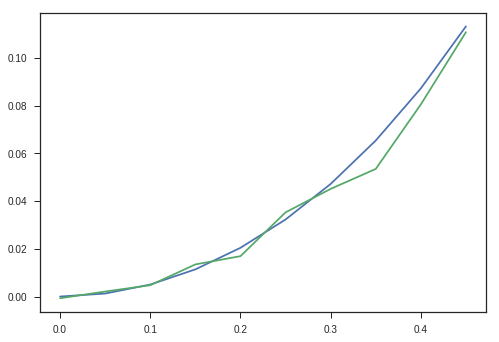

In [22]:
plt.plot(np.arange(0, 0.5, 0.05), emi)
plt.plot(np.arange(0, 0.5, 0.05), ami)